In [4]:
SEED = 123321
MISSING = -9999

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
df = pd.read_csv("../data/processed/data_encoded_stacking_final.csv")

In [6]:
df.shape

(39325, 353)

In [7]:
df_labeled = df[df["test"] == 0].drop(columns=["test"]).set_index("id")
df_unlabeled = df[df["test"] == 1].drop(columns=["test"]).set_index("id")

In [8]:
X = df_labeled.drop(columns=["satisfied"])
y = df_labeled["satisfied"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

In [9]:
X_train["satisfied"] = y_train
X_test["satisfied"] = y_test
X_online = df_unlabeled.drop(columns=["satisfied"]) # should be all null

In [13]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_online = X_online.reset_index(drop=True)

In [17]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x_train = imp.fit_transform(x_train)
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x = imp.fit_transform(x)
        return self.clf.predict_proba(x)[:,1]

In [18]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [19]:
class XgbWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [20]:
class LightGBMWrapper(object):
    def __init__(self, seed=0, params=None):
        params['seed'] = seed
        self.params = params

    def train(self, x_train, y_train):
        dtrain = lgb.Dataset(x_train,label=y_train)
        bst = lgb.cv(self.params, dtrain, num_boost_round=1000, nfold=3, early_stopping_rounds=30) #cv寻找较优的迭代次数
        self.lgbc = lgb.train(self.params,dtrain,num_boost_round=len(bst['auc-mean']))

    def predict(self, x):
        return self.lgbc.predict(np.array(x))

In [23]:
class ModelStacking():
    def __init__(self, train_data, test_data, online_data, predictors, models=['et','rf','xgb','cb','lgb'], dep='y',nfolds=5, seed=0):
        '''
        train_data: DataFrame, training data;
        test_data: DataFrame, test data (labeled);
        online_data: DataFrame, online data (unlabeled);
        predictors：list or array, feature column name;
        dep: str, label column name;
        models: list, models name;
        nfolds: int, number of folds;
        seed: int, random seed number;
        '''
        self.train_data = train_data # training data
        self.test_data = test_data # test data (labeled)
        self.online_data = online_data # online data (unlabeled)
        self.predictors = predictors # feature columns name
        self.dep = dep # label column name
        self.nfolds = nfolds # number of folds
        self.seed = seed # random seed number
        self.ntrain = self.train_data.shape[0]
        self.ntest = self.test_data.shape[0]
        self.nonline = self.online_data.shape[0]
        self.models = models # models name
        
        self.params_list() # hyper-params of each model

    def get_oof(self,clf):
        '''
        clf: model wrapper object;
        return features (probabilities) for the next layers;
        '''
        kf = KFold(n_splits = self.nfolds, shuffle=True, random_state=0)
        oof_train = np.zeros((self.ntrain,)) # container for training results
        oof_test = np.zeros((self.ntest,)) # container for test results
        oof_online = np.zeros((self.nonline,)) # container for online results
        oof_test_skf = np.empty((self.nfolds, self.ntest)) # container for final (nfold) test results
        oof_online_skf = np.empty((self.nfolds, self.nonline)) # container for final (nfold) online results
    
        for i, (train_index, test_index) in enumerate(kf.split(self.train_data)):
            x_tr = self.train_data.loc[train_index,self.predictors]
            y_tr = self.train_data[self.dep].loc[train_index]
            x_te = self.train_data.loc[test_index,self.predictors]
    
            # train on the ith fold data
            clf.train(x_tr, y_tr)

            # save the ith fold result
            oof_train[test_index] = clf.predict(x_te)
            oof_test_skf[i, :] = clf.predict(self.test_data[self.predictors])
            oof_online_skf[i,:] = clf.predict(self.online_data[self.predictors])
    
        # averaging out-of-fold predictions for test and online results
        oof_test[:] = oof_test_skf.mean(axis=0)
        oof_online[:] = oof_online_skf.mean(axis=0)
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_online.reshape(-1, 1)

    def params_list(self):
        '''
        : initialize params
        '''
        
        et_params = {
            'n_jobs': 4,
            'n_estimators': 300,
            'max_features': 'sqrt',
            'max_depth': 38,
            'min_samples_leaf': 2,
        }
        
        lr_params = {
            'n_jobs': 1,
            'solver': 'saga',
            'penalty': 'l1',
            'C': 0.116,
        }
        
        rf_params = {
            'n_jobs': 4,
            'n_estimators': 100,
            'max_features': 'sqrt',
            'max_depth': 24,
            'min_samples_leaf': 2,
        }
        
        xgb_params ={
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'max_depth': 8,
            'subsample': 0.6,
            'scale_pos_weight': 0.7,
            'colsample_bytree': 0.8,
            'colsample_bynode': 0.7,
            'colsample_bylevel': 0.6,
            'eta': 0.1,
            'lambda': 10,
            'min_child_weight': 1,
            'seed': 0,
            'nthread': 4,
            'silent': 1,
            'eval_metric': 'auc',
            'missing': MISSING,
        }
        
        cb_params = {
            'iterations': 300,
            'learning_rate': 0.1,
            'depth': 8,
            'l2_leaf_reg': 3,
            'bootstrap_type': 'Bernoulli',
            'subsample': 0.75,
            'scale_pos_weight': 5,
            'eval_metric': 'AUC',
            'od_type': 'Iter',
            'logging_level': 'Silent',
            'allow_writing_files': False,
        }
        
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_weight': 1,
            'num_leaves': 2 ** 5,
            'lambda_l2': 10,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'seed': 0,
            'colsample_bytree': 0.8,
            'nthread': 4
        }
        
        
        self.params_dic = {}
        self.params_dic['et_params'] = et_params
        self.params_dic['rf_params'] = rf_params
        self.params_dic['xgb_params'] = xgb_params
        self.params_dic['cb_params'] = cb_params
        self.params_dic['lgb_params'] = lgb_params
        self.params_dic['lr_params'] = lr_params

    def model_train_predict(self):
        '''
        ：train the selected models and generate results
        '''
        self.build_models = {}
        self.models_oof_return = {}
        for mm in self.models:
            if mm == 'et':
                self.build_models['et'] = SklearnWrapper(clf=ExtraTreesClassifier, seed=self.seed, params=self.params_dic['et_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['et'])
                self.models_oof_return['et'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('et-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))
            elif mm == 'rf':
                self.build_models['rf'] = SklearnWrapper(clf=RandomForestClassifier, seed=self.seed, params=self.params_dic['rf_params'])
                rf_oof_train, rf_oof_test, rf_oof_online = self.get_oof(self.build_models['rf'])
                self.models_oof_return['rf'] = [rf_oof_train, rf_oof_test, rf_oof_online]
                print ('rf-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],rf_oof_train))
            elif mm == 'cb':
                self.build_models['cb'] = CatboostWrapper(clf= CatBoostClassifier, seed=self.seed, params=self.params_dic['cb_params'])
                cb_oof_train, cb_oof_test, cb_oof_online = self.get_oof(self.build_models['cb'])
                self.models_oof_return['cb'] = [cb_oof_train, cb_oof_test, cb_oof_online]
                print ('cb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],cb_oof_train))
            elif mm == 'lgb':
                self.build_models['lgb'] = LightGBMWrapper(seed=self.seed, params=self.params_dic['lgb_params'])
                lgb_oof_train, lgb_oof_test, lgb_oof_online = self.get_oof(self.build_models['lgb'])
                self.models_oof_return['lgb'] = [lgb_oof_train, lgb_oof_test, lgb_oof_online]
                print ('lgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],lgb_oof_train))
            elif mm == 'xgb':
                self.build_models['xgb'] = XgbWrapper(clf=xgb.XGBClassifier, seed=self.seed, params=self.params_dic['xgb_params'])
                xgb_oof_train, xgb_oof_test, xcb_oof_online = self.get_oof(self.build_models['xgb'])
                self.models_oof_return['xgb'] = [xgb_oof_train, xgb_oof_test, xcb_oof_online]
                print ('xgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],xgb_oof_train))
            elif mm == 'lr':
                self.build_models['lr'] = SklearnWrapper(clf=LogisticRegression, seed=self.seed, params=self.params_dic['lr_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['lr'])
                self.models_oof_return['lr'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('lr-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))

    def stacking(self):
        '''
        : train level 2 model and generate final results
        '''
        self.model_train_predict()

        for i in range(len(self.models)):
            if i == 0:
                x_train = self.models_oof_return[self.models[i]][0]
                x_test = self.models_oof_return[self.models[i]][1]
                x_online = self.models_oof_return[self.models[i]][2]
            else:
                x_train = np.concatenate((x_train,self.models_oof_return[self.models[i]][0]), axis=1)
                x_test = np.concatenate((x_test,self.models_oof_return[self.models[i]][1]), axis=1)
                x_online = np.concatenate((x_online,self.models_oof_return[self.models[i]][2]), axis=1)
                
        cor = pd.DataFrame(x_train).corr()
        sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
        plt.show()
        
        # use xgb as level 2 model
        dtrain = xgb.DMatrix(x_train, label=self.train_data[self.dep])
        dtest = xgb.DMatrix(x_test)
        donline = xgb.DMatrix(x_online)
        
        xgb_params = {
            'seed': 0,
            'colsample_bytree': 0.8,
            'silent': 1,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'objective': 'binary:logistic',
            'max_depth': 2,
            'num_parallel_tree': 1,
            'min_child_weight': 1,
            'eval_metric': 'auc'
        }
        
        res = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=self.seed, stratified=False,
             early_stopping_rounds=10, verbose_eval=False, show_stdv=True) # use cv to find best # iterations 
        best_nrounds = res.shape[0]
        cv_mean = res.iloc[-1, 0]
        cv_std = res.iloc[-1, 1]        
        print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std)) # cv performance
        print("Best nrounds: {}".format(best_nrounds)) # best # boosting iterations
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
        dtest_prob = gbdt.predict(dtest)
        donline_prob = gbdt.predict(donline)
        print ('Ensemble-test %.5f'%roc_auc_score(self.test_data[self.dep], dtest_prob)) # test performance
        return donline_prob, dtest_prob

rf-CV AUC is 0.88540
lr-CV AUC is 0.88035
cb-CV AUC is 0.89153
xgb-CV AUC is 0.88959


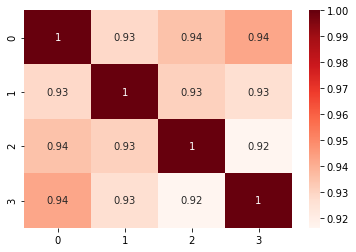

Ensemble-CV: 0.8969116666666666+0.0008414060982796683
Best nrounds: 43
Ensemble-test 0.89405


In [24]:
ms = ModelStacking(X_train,
                   X_test,
                   X_online,
                   list(X_train.columns[:-1]),
                   models = [
                       'rf',
                       'lr',
                       'cb',
                       'xgb',
                   ],
                   dep='satisfied',
                   nfolds=6,
                   seed=SEED
                  )
c, t = ms.stacking()
# X_train, y_train, X_test, y_test = ms.stacking()

In [43]:
res = pd.DataFrame(y_test)
res["pred"] = t

In [48]:
import seaborn as sns

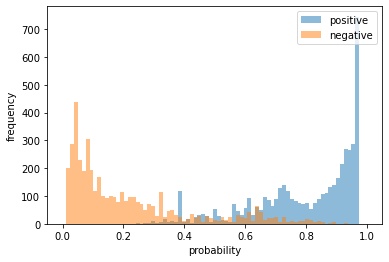

In [58]:
pos = res[res["satisfied"].astype(bool).values]["pred"]
neg = res[~(res["satisfied"].astype(bool).values)]["pred"]

bins = np.linspace(0, 1, 80)

plt.hist(pos, bins, alpha=0.5, label='positive')
plt.hist(neg, bins, alpha=0.5, label='negative')
plt.legend(loc='upper right')
plt.xlabel("probability")
plt.ylabel("frequency")
plt.show()